In [39]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import h5py
import inspect
from tqdm import tqdm
import sys
import math
import presto
from presto import lockin, utils, hardware
from presto.hardware import AdcFSample, AdcMode, DacFSample, DacMode
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [40]:
# Load Exp Data
def load_ExpData(file_, idx_str_):
    # Open hdf5 file
    with h5py.File(file_, "r") as dataset:
        # Data
        return dict(freq_comb=np.asarray(dataset[idx_str_]["freq comb"]),
                    freq_pump=np.asarray(dataset[idx_str_]["freq pumps"]),
                    pump_pwr_data=np.asarray(dataset[idx_str_]["pump pwr sweep"]),
                    pump_phase_data=np.asarray(dataset[idx_str_]["pump phase sweep"]),
                    df=np.asarray(dataset[idx_str_]["df"]),
                    USB=np.asarray(dataset[idx_str_]["USB"]),
                    )

## Extract quadrature data

In [41]:

file = r'/home/nanophys-meas/Desktop/Jai Master Thesis/Presto-Measurement-Scripts/I:/JPA-Data/2026-01/Covariance/2026-01-15_11_35_26.hdf5'
run = r'2026-01-15_11_35_26'


usb = load_ExpData(
    file_ = file,
    idx_str_= run
    )['USB']
usb=np.array(usb)

freqs = load_ExpData(
    file_ = file,
    idx_str_= run
    )['freq_comb']

len(usb)

1000000

In [42]:
df = load_ExpData(
    file_ = file,
    idx_str_= run
    )['df']

print(df/1e6, 'MHz')

0.1 MHz


## Create covariance matrix

In [43]:
def covariance_matrix(usb_arr):
    real_part = np.real(usb_arr)
    imag_part = np.imag(usb_arr)

    # Stack quadratures: [Re0, Im0, Re1, Im1, ...]
    xp_mat = np.empty((usb_arr.shape[0], usb_arr.shape[1]*2))
    xp_mat[:, 0::2] = real_part
    xp_mat[:, 1::2] = imag_part

    # Covariance over samples
    return np.cov(xp_mat, rowvar=False)

cov_mat = covariance_matrix(usb)

def cov_rotation(cov_mat, theta):
    """Rotate covariance matrix by angle theta (radians)"""
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s],
                  [s, c]])
    
    N = cov_mat.shape[0] // 2
    R_big = np.zeros((2*N, 2*N))
    for i in range(N):
        R_big[2*i:2*i+2, 2*i:2*i+2] = R
    
    return R_big @ cov_mat @ R_big.T

theta = -np.pi/4  # 45 degrees
cov_mat = cov_rotation(cov_mat, theta)

## Plot

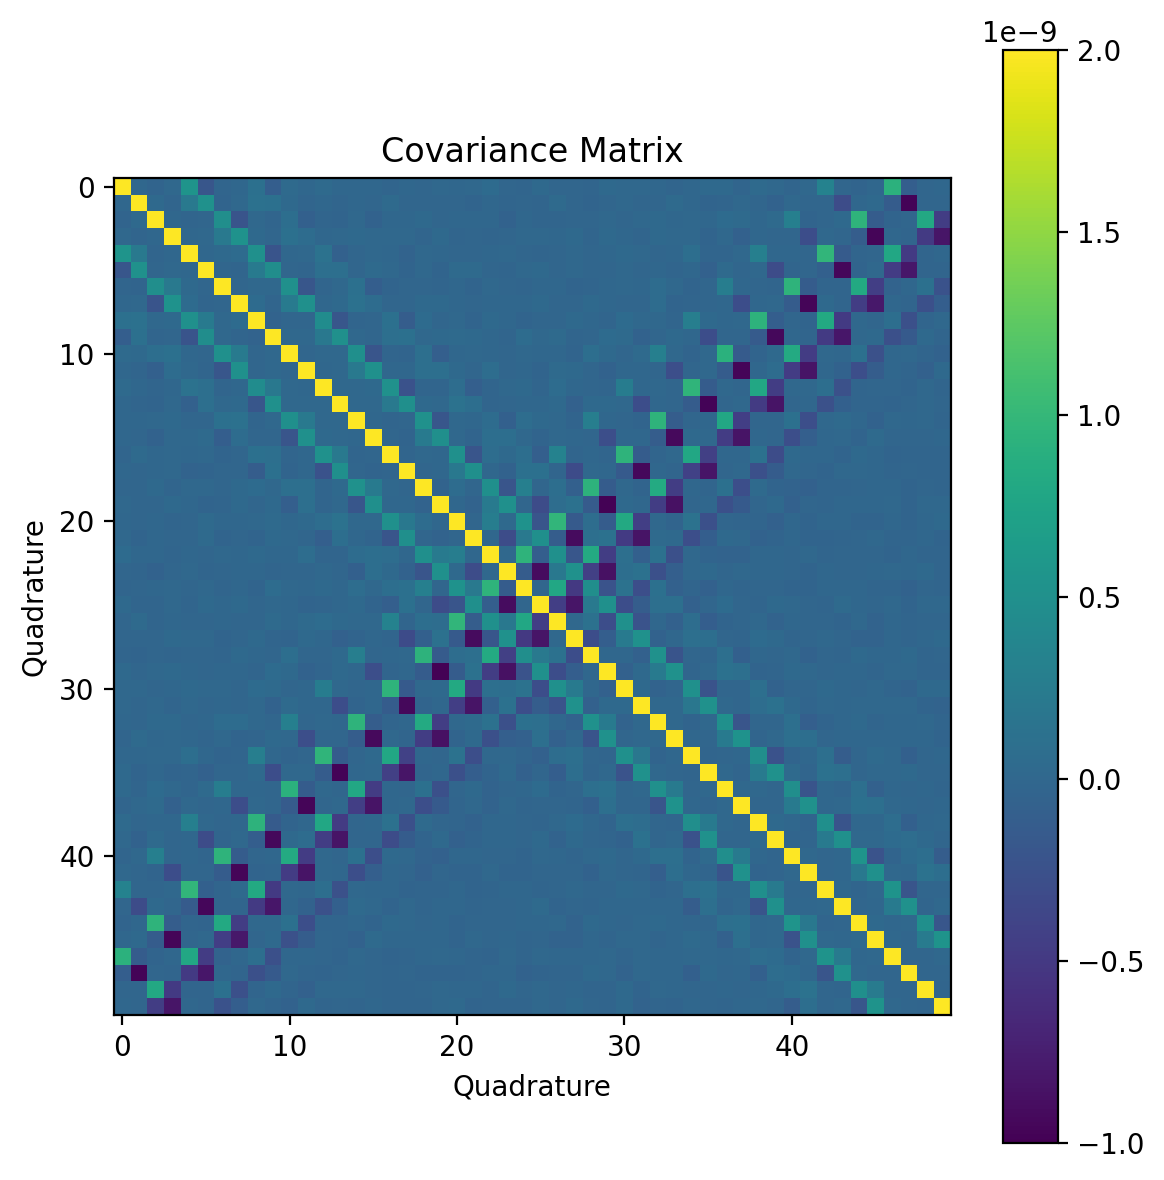

In [45]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=200)

im = ax.imshow(
    np.real(cov_mat),
    aspect='equal',
    cmap='viridis',
    origin='upper',
    vmax=2e-9,
    vmin=-1e-9
)

cbar = fig.colorbar(im, ax=ax)


ax.set_xlabel("Quadrature")
ax.set_ylabel("Quadrature")
ax.set_title("Covariance Matrix")


fig.tight_layout()

